# Force Alignment using Seq2Seq HuggingFace

Forced alignment is a technique to take an orthographic transcription of an audio file and generate a time-aligned version. In this example, I am going to use Malay and Singlish models.

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/force-alignment-seq2seq-huggingface](https://github.com/huseinzol05/malaya-speech/tree/master/example/force-alignment-seq2seq-huggingface).
    
</div>

<div class="alert alert-warning">

This module is not language independent, so it not save to use on different languages. Pretrained models trained on hyperlocal languages.
    
</div>

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline
import IPython.display as ipd
import matplotlib.pyplot as plt
from malaya_speech.utils.aligner import plot_alignments

`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


### List available Force Aligner model

In [3]:
malaya_speech.force_alignment.seq2seq.available_huggingface()

,Size (MB),malay-malaya,malay-fleur102,singlish,Language
mesolitica/finetune-whisper-tiny-ms-singlish,151,"{'WER': 0.20141585, 'CER': 0.071964908}","{'WER': 0.235680975, 'CER': 0.0986880877}","{'WER': 0.09045121, 'CER': 0.0481965}","[malay, singlish]"
mesolitica/finetune-whisper-tiny-ms-singlish-v2,151,"{'WER': 0.20141585, 'CER': 0.071964908}","{'WER': 0.22459602, 'CER': 0.089406469}","{'WER': 0.138882971, 'CER': 0.074929807}","[malay, singlish]"
mesolitica/finetune-whisper-base-ms-singlish-v2,290,"{'WER': 0.172632664, 'CER': 0.0680027682}","{'WER': 0.1837319118, 'CER': 0.0599804251}","{'WER': 0.111506313, 'CER': 0.05852830724}","[malay, singlish]"
mesolitica/finetune-whisper-small-ms-singlish-v2,967,"{'WER': 0.13189875561, 'CER': 0.0434602169}","{'WER': 0.13277694, 'CER': 0.0478108612}","{'WER': 0.09489335668, 'CER': 0.05045327551}","[malay, singlish]"


### Load Transducer Aligner model

```python
def huggingface(
    model: str = 'mesolitica/finetune-whisper-base-ms-singlish-v2',
    force_check: bool = True,
    **kwargs,
):
    """
    Load Finetuned models from HuggingFace.

    Parameters
    ----------
    model : str, optional (default='mesolitica/finetune-whisper-base-ms-singlish-v2')
        Check available models at `malaya_speech.force_alignment.seq2seq.available_huggingface()`.
    force_check: bool, optional (default=True)
        Force check model one of malaya model.
        Set to False if you have your own huggingface model.

    Returns
    -------
    result : malaya_speech.model.huggingface.Seq2SeqAligner class
    """
```

In [4]:
model = malaya_speech.force_alignment.seq2seq.huggingface(model = 'mesolitica/finetune-whisper-base-ms-singlish-v2')

### Load sample

#### Malay samples

In [5]:
malay1, sr = malaya_speech.load('speech/example-speaker/shafiqah-idayu.wav')
malay2, sr = malaya_speech.load('speech/example-speaker/haqkiem.wav')

In [6]:
texts = ['nama saya shafiqah idayu',
        'sebagai pembangkang yang matang dan sejahtera pas akan menghadapi pilihan raya umum dan tidak menumbang kerajaan dari pintu belakang']

In [7]:
ipd.Audio(malay2, rate = sr)

#### Singlish samples

In [8]:
import json
import os
from glob import glob

with open('speech/imda/output.json') as fopen:
    data = json.load(fopen)
    
data

{'221931702.WAV': 'wantan mee is a traditional local cuisine',
 '221931818.WAV': 'ahmad khan adelene wee chin suan and robert ibbetson',
 '221931727.WAV': 'saravanan gopinathan george yeo yong boon and tay kheng soon'}

In [9]:
wavs = glob('speech/imda/*.WAV')
wavs

['speech/imda/221931727.WAV',
 'speech/imda/221931818.WAV',
 'speech/imda/221931702.WAV']

In [10]:
y, sr = malaya_speech.load(wavs[0])

In [11]:
ipd.Audio(y, rate = sr)

### Predict

```python
def predict(
    self,
    input,
    transcription: str,
    lang: str = 'ms',
    median_filter_size: int = 7,
):
    """
    Transcribe input, will return a string.
    Based on https://github.com/openai/whisper/blob/main/notebooks/Multilingual_ASR.ipynb

    Parameters
    ----------
    input: np.array
        np.array or malaya_speech.model.frame.Frame.
    transcription: str
        transcription of input audio.
    lang: str, optional (default='ms')
        if you feed singlish speech, it is better to give `en` language.
    median_filter_size: int, optional (default=7)
        sliding median size.
    Returns
    -------
    result: Dict[chars_alignment, words_alignment, alignment]
    """
```

Force alignment Seq2Seq required `dtw-python`, make sure you already installed,

```bash
pip install dtw-python
```

#### Predict Malay

Our original text is: 'sebagai pembangkang yang matang dan sejahtera pas akan menghadapi pilihan raya umum dan tidak menumbang kerajaan dari pintu belakang'

In [12]:
results = model.predict(malay2, texts[1])

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [13]:
results.keys()

dict_keys(['subwords_alignment', 'words_alignment', 'alignment', 'alignment_x', 'alignment_y', 'xticks', 'xticklabels', 'yticks', 'yticklabels'])

In [14]:
results['words_alignment']

[{'text': 'sebagai', 'start': 0.0, 'end': 0.26},
 {'text': 'pembangkang', 'start': 0.26, 'end': 1.06},
 {'text': 'yang', 'start': 1.06, 'end': 1.1400000000000001},
 {'text': 'matang', 'start': 1.1400000000000001, 'end': 1.7},
 {'text': 'dan', 'start': 1.7, 'end': 1.84},
 {'text': 'sejahtera', 'start': 1.84, 'end': 2.5},
 {'text': 'pas', 'start': 2.5, 'end': 2.66},
 {'text': 'akan', 'start': 2.66, 'end': 3.08},
 {'text': 'menghadapi', 'start': 3.08, 'end': 3.7600000000000002},
 {'text': 'pilihan', 'start': 3.7600000000000002, 'end': 4.32},
 {'text': 'raya', 'start': 4.32, 'end': 4.72},
 {'text': 'umum', 'start': 4.72, 'end': 5.12},
 {'text': 'dan', 'start': 5.12, 'end': 5.24},
 {'text': 'tidak', 'start': 5.24, 'end': 5.74},
 {'text': 'menumbang', 'start': 5.74, 'end': 6.2},
 {'text': 'kerajaan', 'start': 6.2, 'end': 6.74},
 {'text': 'dari', 'start': 6.74, 'end': 6.76},
 {'text': 'pintu', 'start': 6.76, 'end': 7.58},
 {'text': 'belakang', 'start': 7.58, 'end': 8.0}]

In [15]:
results['alignment'].shape

(48, 411)

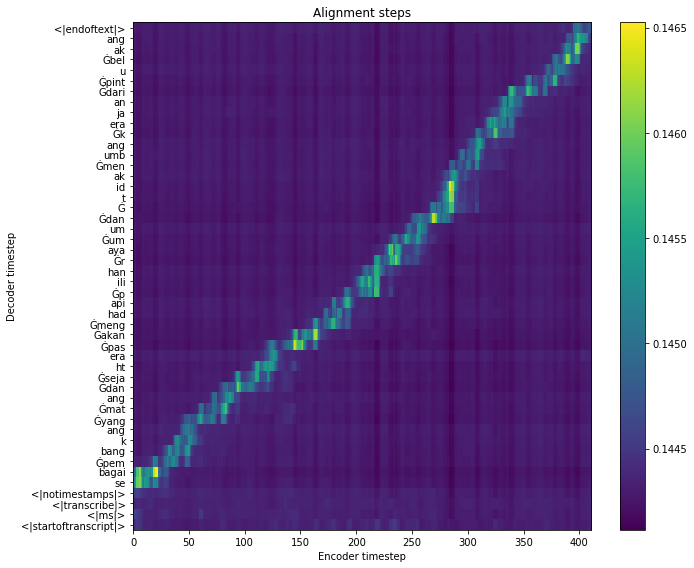

In [19]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    results['alignment'],
    aspect='auto',
    origin='lower',
    interpolation='none')
ax.set_yticks(range(len(results['yticklabels'])))
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(results['yticklabels'])
fig.colorbar(im, ax=ax)
xlabel = 'Encoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Decoder timestep')
plt.tight_layout()
plt.show()

#### Predict Singlish

Our original text is: 'saravanan gopinathan george yeo yong boon and tay kheng soon'

In [22]:
results = model.predict(y, data[os.path.split(wavs[0])[1]])

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [23]:
results.keys()

dict_keys(['subwords_alignment', 'words_alignment', 'alignment', 'alignment_x', 'alignment_y', 'xticks', 'xticklabels', 'yticks', 'yticklabels'])

In [24]:
results['words_alignment']

[{'text': 'saravanan', 'start': 0.06, 'end': 1.54},
 {'text': 'gopinathan', 'start': 1.54, 'end': 2.08},
 {'text': 'george', 'start': 2.08, 'end': 3.4},
 {'text': 'yeo', 'start': 3.4, 'end': 3.84},
 {'text': 'yong', 'start': 3.84, 'end': 4.34},
 {'text': 'boon', 'start': 4.34, 'end': 4.88},
 {'text': 'and', 'start': 4.88, 'end': 5.2},
 {'text': 'tay', 'start': 5.2, 'end': 6.22},
 {'text': 'kheng', 'start': 6.22, 'end': 6.38},
 {'text': 'soon', 'start': 6.38, 'end': 6.4}]

In [25]:
results['subwords_alignment']

[{'text': '<|startoftranscript|>', 'start': 0.0, 'end': 0.0},
 {'text': '<|ms|>', 'start': 0.0, 'end': 0.02},
 {'text': '<|transcribe|>', 'start': 0.02, 'end': 0.06},
 {'text': '<|notimestamps|>', 'start': 0.06, 'end': 0.06},
 {'text': 's', 'start': 0.06, 'end': 0.74},
 {'text': 'ar', 'start': 0.74, 'end': 0.9400000000000001},
 {'text': 'avan', 'start': 0.9400000000000001, 'end': 1.16},
 {'text': 'an', 'start': 1.16, 'end': 1.54},
 {'text': 'Ġgo', 'start': 1.54, 'end': 1.86},
 {'text': 'pin', 'start': 1.86, 'end': 1.8800000000000001},
 {'text': 'athan', 'start': 1.8800000000000001, 'end': 2.08},
 {'text': 'Ġge', 'start': 2.08, 'end': 2.5},
 {'text': 'orge', 'start': 2.5, 'end': 3.4},
 {'text': 'Ġye', 'start': 3.4, 'end': 3.66},
 {'text': 'o', 'start': 3.66, 'end': 3.84},
 {'text': 'Ġy', 'start': 3.84, 'end': 4.26},
 {'text': 'ong', 'start': 4.26, 'end': 4.34},
 {'text': 'Ġbo', 'start': 4.34, 'end': 4.64},
 {'text': 'on', 'start': 4.64, 'end': 4.88},
 {'text': 'Ġand', 'start': 4.88, 'en

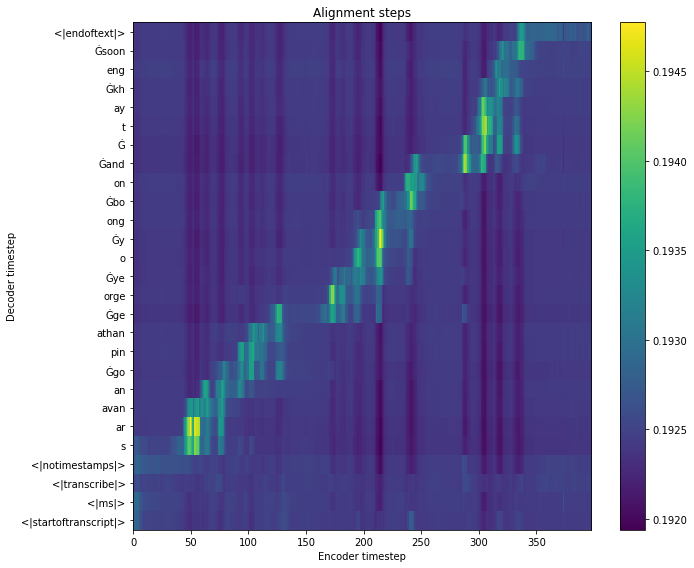

In [26]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    results['alignment'],
    aspect='auto',
    origin='lower',
    interpolation='none')
ax.set_yticks(range(len(results['yticklabels'])))
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(results['yticklabels'])
fig.colorbar(im, ax=ax)
xlabel = 'Encoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Decoder timestep')
plt.tight_layout()
plt.show()

### What if we give wrong transcription?

In [28]:
results = model.predict(y, 'husein sangat comel')
results.keys()

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


dict_keys(['subwords_alignment', 'words_alignment', 'alignment', 'alignment_x', 'alignment_y', 'xticks', 'xticklabels', 'yticks', 'yticklabels'])

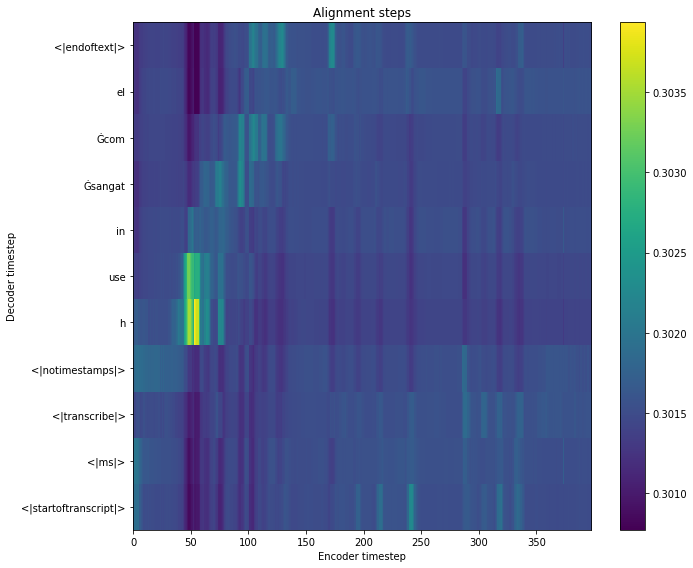

In [29]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    results['alignment'],
    aspect='auto',
    origin='lower',
    interpolation='none')
ax.set_yticks(range(len(results['yticklabels'])))
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(results['yticklabels'])
fig.colorbar(im, ax=ax)
xlabel = 'Encoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Decoder timestep')
plt.tight_layout()
plt.show()